<a href="https://colab.research.google.com/github/atripathy86/MD/blob/main/notebook0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, we show how to extract the full QM9 dataset, convert SMILE strings to SELFIEs and one-hot vectors. We also show how to compute different features using RDkit and put together a featurized dataset.

### Note: These are example representations (maybe graph representations or so) of the molecules but feel free to choose some other representations and also explore different target variables as included within the QM9 dataset.

- We extract information from QM9 dataset, particularly from each molecule (given orignially in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.
- Link to orginal dataset: http://quantum-machine.org/datasets/
- Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

- Adapted from notebook prepared by Ayana Ghosh (SMIILES to SELFIES part), research.aghosh@gmail.com

## Install RDkit and Selfies

In [ ]:
!pip install rdkit-pypi
!pip install selfies --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 25.2 MB/s eta 0:00:00


Import libraries

In [ ]:
import numpy as np
import pandas as pd

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw

import torch
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize

import selfies as sf

In [ ]:
# @title Utility functions
def parse_float(s: str) -> float:
    try:
        return float(s)
    except ValueError:
        base, power = s.split('*^')
        return float(base) * 10**float(power)

def parse_xyz(filename):
    """
    Parses QM9 specific xyz files.
    :param filename: str path to file
    :return:
    """
    num_atoms = 0
    scalar_properties = []
    atomic_symbols = []
    xyz = []
    charges = []
    harmonic_vibrational_frequencies = []
    smiles = ''
    inchi = ''
    with open(filename, 'r') as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                num_atoms = int(line)
            elif line_num == 1:
                scalar_properties = [float(i) for i in line.split()[2:]]
            elif 2 <= line_num <= 1 + num_atoms:
                atom_symbol, x, y, z, charge = line.split()
                atomic_symbols.append(atom_symbol)
                xyz.append([parse_float(x), parse_float(y), parse_float(z)])
                charges.append(parse_float(charge))
            elif line_num == num_atoms + 2:
                harmonic_vibrational_frequencies = [float(i) for i in line.split()]
            elif line_num == num_atoms + 3:
                smiles = line.split()[0]
            elif line_num == num_atoms + 4:
                inchi = line.split()[0]

    result = {
        'num_atoms': num_atoms,
        'atomic_symbols': atomic_symbols,
        'pos': torch.tensor(xyz),
        'charges': np.array(charges),
        'harmonic_oscillator_frequencies': harmonic_vibrational_frequencies,
        'smiles': smiles,
        'inchi': inchi
    }
    scalar_property_labels = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo',
                              'gap', 'r2', 'zpve', 'u0', 'u', 'h', 'g', 'cv']
    scalar_properties = dict(zip(scalar_property_labels, scalar_properties))
    result.update(scalar_properties)
    return result

## Download the data

## The full dataset is downloadable from this link:
https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904

In [ ]:
#the link may not work directly but you can download a
#local copy of the full dataset with .xyz files from it

#!gdown https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF

Generate lists of SMILE strings and append with properties that we can directly retrieve from the QM9 dataset

In [ ]:
# !mkdir /content/Molecules
# !tar -C Molecules -xvf /content/dsgdb9nsd.xyz.tar.bz2

mkdir: cannot create directory ‘/content/Molecules’: File exists
tar: /content/dsgdb9nsd.xyz.tar.bz2: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


Read in the .xyz files and the molecular properties as included in the dataset

In [ ]:
smiles = []
enthalpy = []
u0 = []
u = []
g = []
alpha = []
r2 = []
mu = []

#may need to change the path
filenames = glob.glob('/content/Molecules/*.xyz')

#may need to go through the full range
for fid in range(5000):
    x = parse_xyz(filenames[fid])

    smiles_loc = x['smiles']
    enthalpy_loc = x['h']
    dipole_moment = x['mu']
    homo_loc = x['homo']
    lumo_loc = x['lumo']
    gap_loc = x['gap']
    zpve_loc = x['zpve']
    u0_loc = x['u0']
    u_loc = x['u']
    g_loc = x['g']
    alpha_loc = x['alpha']
    r2_loc = x['r2']

    smiles.append(smiles_loc)
    mu.append(dipole_moment)
    enthalpy.append(enthalpy_loc)
    u0.append(u0_loc)
    u.append(u_loc)
    g.append(g_loc)
    alpha.append(alpha_loc)
    r2.append(r2_loc)

In additionan to QM9 descriptors, let's compute few basic features and put together a dataset. Features we compute:
- molecular weight,
- topological polar surface area,
- molar log P,
- number of hydrogen bond donors,
- acceptors,
- valence electrons,
- maximum partial charge,
- minimum partial charge,
- number of rotatable bonds,
- number of ring counts,
- number of stereocenters

In [ ]:
mol_wt, tpsa, logp_ml, hbd, hba  = [], [], [], [], []
vale, partialcg_max, partialcg_min, rotbd, ringct, stereoct = [], [], [], [], [], []

for i in range(len(smiles)):

    m = Chem.MolFromSmiles(smiles[i])
    mol_wt_l = Descriptors.ExactMolWt(m)
    tpsa_l, logp_l = Descriptors.TPSA(m), Descriptors.MolLogP(m)
    hbd_l, hba_l = Descriptors.NumHDonors(m), Descriptors.NumHAcceptors(m)
    vale_l = Descriptors.NumValenceElectrons(m),
    partialcharge_max_l, partialcharge_min_l = Descriptors.MaxPartialCharge(m), Descriptors.MinPartialCharge(m)
    rotbd_l = Descriptors.NumRotatableBonds(m)
    ring_ct, stereo_cent = Descriptors.RingCount(m), rdMolDescriptors.CalcNumAtomStereoCenters(m)

    mol_wt.append(mol_wt_l)
    tpsa.append(tpsa_l)
    logp_ml.append(logp_l)
    hbd.append(hbd_l)
    hba.append(hba_l)
    vale.append(vale_l)
    partialcg_max.append(partialcharge_max_l)
    partialcg_min.append(partialcharge_min_l)
    rotbd.append(rotbd_l)
    ringct.append(ring_ct)
    stereoct.append(stereo_cent)

New dataset with few features with SMILE strings

In [ ]:
df = pd.DataFrame({'smiles': smiles, 'mole_logp': logp_ml,'tpsa': tpsa, 'mol_wt' : mol_wt,
                   'hbd': hbd, 'hba':hba, 'valencee':vale, 'max_partialcharge':partialcg_max, 'min_partialcharge':partialcg_min,
                   'rotatablebd':rotbd, 'ringct':ringct, 'stereocent': stereoct, 'dipole_moment':mu, 'enthalpy': enthalpy})

In [ ]:
df

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment,enthalpy
0,CC1C2C3C1C(C)(C)N23,1.09730,3.01,123.104799,0,1,"(50,)",0.031211,-0.288190,0,3,5,1.6097,-367.147794
1,C#CC#CC1CN1,-0.40520,21.94,91.042199,1,1,"(34,)",0.082698,-0.300043,0,1,1,1.1151,-286.146877
2,CC1=COC=C1C=O,1.40052,30.21,110.036779,0,2,"(42,)",0.153043,-0.471575,1,1,0,3.2172,-382.576265
3,CC1C2C=CC(=O)C12O,0.12230,37.30,124.052429,1,2,"(48,)",0.187277,-0.380762,0,2,3,2.9412,-421.831835
4,CC1COC(C1)C=O,0.61030,26.30,114.068080,0,2,"(46,)",0.148264,-0.370464,1,1,2,3.1893,-384.947455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,OC1CCC2(NC12)C=O,-0.94940,59.24,127.063329,2,3,"(50,)",0.141249,-0.391414,1,2,3,1.6268,-439.071783
4996,COCC#CCNC=O,-0.61780,38.33,127.063329,1,2,"(50,)",0.207375,-0.372020,3,0,0,4.6315,-439.048899
4997,O=C1CCN2N=CN=C12,-0.13550,47.78,123.043262,0,4,"(46,)",0.201128,-0.290587,0,2,0,4.1198,-432.907897
4998,CCC1(O)CC2(CN2)C1,0.26330,42.17,127.099714,2,2,"(52,)",0.068087,-0.389757,1,2,0,2.2262,-404.303341


## Convert SMILEs to SELFIEs

In [ ]:
# smiles

The SELFIES have some limitations on acceptable bonding. So we refine the data set to remove the molecules that do not fit into supported semantic constraints.

In [ ]:
selfies_dataset = []
error_smiles = []

for i in range(len(smiles)):
    try:
        local_sf = sf.encoder(smiles[i])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(smiles[i])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

Error encoding SMILES at index 1004: input violates the currently-set semantic constraints
	SMILES: O=N(=O)C1=NOC=N1
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 1194: input violates the currently-set semantic constraints
	SMILES: NC1=C(NN=C1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 2148: input violates the currently-set semantic constraints
	SMILES: CC1=NNN=C1N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 2344: input violates the currently-set semantic constraints
	SMILES: O=N(=O)C1=CN=CN=C1
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 4409: input violates the currently-set semantic constraints
	SMILES: NC1=C(C=NO1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 4427: input violates the currently-set semant

Let's see what these molecules are....

In [ ]:
error_smiles_set = set(error_smiles)
error_smiles_set

{'CC1=CC(=NO1)N(=O)=O',
 'CC1=NNN=C1N(=O)=O',
 'NC1=C(C=NO1)N(=O)=O',
 'NC1=C(NN=C1)N(=O)=O',
 'O=N(=O)C1=CN=CN=C1',
 'O=N(=O)C1=CNC=C1',
 'O=N(=O)C1=NOC=N1'}

... how many of them are there

In [ ]:
df['smiles'].isin(error_smiles_set).sum()

7

And remove them from the dataframe

In [ ]:
df_filtered = df[~df['smiles'].isin(error_smiles_set)]
df_filtered.tail(5)

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment,enthalpy
4995,OC1CCC2(NC12)C=O,-0.9494,59.24,127.063329,2,3,"(50,)",0.141249,-0.391414,1,2,3,1.6268,-439.071783
4996,COCC#CCNC=O,-0.6178,38.33,127.063329,1,2,"(50,)",0.207375,-0.372020,3,0,0,4.6315,-439.048899
4997,O=C1CCN2N=CN=C12,-0.1355,47.78,123.043262,0,4,"(46,)",0.201128,-0.290587,0,2,0,4.1198,-432.907897
4998,CCC1(O)CC2(CN2)C1,0.2633,42.17,127.099714,2,2,"(52,)",0.068087,-0.389757,1,2,0,2.2262,-404.303341
4999,CC12CC3CC1CC3O2,1.5738,9.23,124.088815,0,1,"(50,)",0.069067,-0.371455,0,4,4,1.3350,-387.089547


Now, let's generate one-hot encodings.

In [ ]:
#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

np.array(one_hot_vectors).shape

(4993, 21, 27)

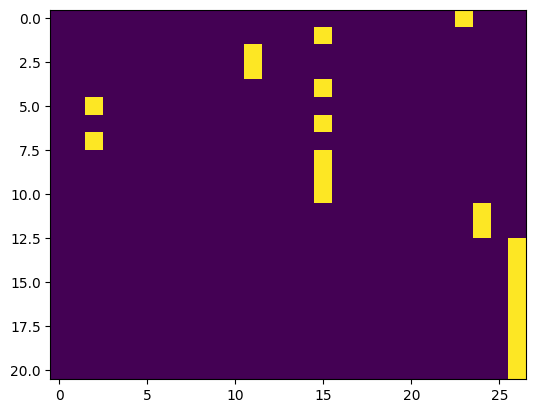

In [ ]:
plt.imshow(np.array(one_hot_vectors)[310,:,:])